# 导入模块

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns 
#sns.set(style="darkgrid")
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False


from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
import time

import warnings  
warnings.filterwarnings("ignore")

import sys
import pymysql
from sqlalchemy import create_engine
import json
import datetime 
from datetime import timedelta ,time 
import re
import os
import sys
# 获取当前工作目录
current_dir = os.getcwd()
# 将模块所在的目录添加到 sys.path
module_dir = os.path.join(current_dir, '../Class_Model')
sys.path.append(module_dir)
from All_Class import All_Model, Week_Model, Data_Clean

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# 实例化All_Model类
all_models = All_Model()
week_models = Week_Model()
clean = Data_Clean()

# 定义数据库连接

In [3]:
def query(sql,
          host="rr-wz9wx0w3yti9d4f6wro.mysql.rds.aliyuncs.com",
          user="ylc",
          password="1O8t5lcJ5aMhwwPEUUjS",
          database = '' ,
          port=3306
         ):   
    conn = pymysql.connect(
        host=host,
        user=user,
        port=port,
        password=password,
        max_allowed_packet=1073741824,
        charset="utf8")
    try:
        df = pd.read_sql(sql, con=conn)
        conn.close()
    except:
        print('error')
        conn.close()
        raise
    return df

# 导入订单数据

In [4]:
sql1 = ''' -- 订单&风控信息  近10日数据   
SELECT date(om.create_time) as create_date,om.create_time,om.id as order_id ,om.order_number,om.all_money 
,om.status
,case om.`status` when  1 then "待支付" when  2 then "待发货" when  3 then "待收货" when  4 then "租赁中" when  5 then "待归还" 
when  6 then "待商家收货" when  7 then "退押中" when  8 then "已完成" when  10 then "已退款" when  11 then "待退押金" when  12 then "待审核" 
when  13 then "订单取消" when  15 then "检测中" when  9999 then "逾期订单" end as status2 
,case when locate('租物',pa.name)>0 or locate('租物',cc.name)>0 or locate('芝麻',pa.name)>0 or locate('芝麻',cc.name)>0  then '芝麻租物' when locate('抖音',pa.name)>0 then '抖音渠道' when locate('搜索',cc.name)>0 then '搜索渠道' else '其他渠道' end as channel_type 
,tod.sku_attributes,tod.product_name,tod.new_actual_money
,case when  locate('租完即送',tod.sku_attributes)>0 then '租完即送' else '租物归还' end as back_type
,om.user_mobile,tmu.true_name,tmu.id_card_num
,top.total_describes,tor.decision_result,om.cancel_reason
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.traceid') end,'"','') as trace_id 
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.rejected') end,'"','') as rejected 
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.result') end,'"','') as result 
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.tips') end,'"','') as tips  
,replace(case when JSON_VALID(tor.risk) THEN JSON_EXTRACT(tor.risk, '$.is_vip') end,'"','') as is_vip
,replace(case when JSON_VALID(tor.risk) THEN JSON_EXTRACT(tor.risk, '$.status') end,'"','') as status_result
,replace(case when JSON_VALID(tor.risk) THEN JSON_EXTRACT(tor.risk, '$.queue_verify_type') end,'"','') as qvt_risk
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.queue_verify_type') end,'"','') as qvt_result
,cc.name as channel_name         -- 来源渠道
,cc.channel_type_id              -- 渠道id
,pa.name as activity_name        -- 活动名称
,om.merchant_id,om.merchant_name
,topay.total_freeze_fund_amount 
,om.buy_service_product,tso.status as service_status 
,om.order_method, om.has_actual, om.relet_status, om.order_finish_date, om.overdue, tprm.rembursement_status, tprm.purchase_amount
,tol.delivery_province_name, tprm.contract_price, tprm.rent_received, tprm.all_rental, tprm.unearned_rent_revenue
,tprm.end_date ,tprm.relet_days, tprm.relet_periods, tos.money, tos.real_pay_money, tos.sesame_promo_money, tos.pay_discount_money
, tos.refund_date, tos.reality_refund_date, om.order_type, pa.type
from  db_digua_business.t_postlease_receivables_monitoring   tprm
left join db_digua_business.t_order  om on tprm.order_id=om.id
left join db_digua_business.t_order_logistics tol on tol.order_id=om.id
left join db_digua_business.t_merchant tmer on tmer.id = om.merchant_id
left join db_digua_business.t_order_risk tor on om.id = tor.order_id
left join db_digua_business.t_order_stages tos on tos.order_id=om.id
-- 备注信息合并 
left join ( SELECT  t.order_id,JSON_ARRAYAGG(t.describes) as total_describes from db_digua_business.t_order_personnel t   GROUP BY 1 ) top 
on om.id = top.order_id 
-- 服务信息
left join  db_digua_business.t_service_order tso  on om.id = tso.order_id 
-- 渠道名称
left join db_digua_business.t_channel cc on om.channel = cc.scene 
-- 活动名称
left join db_digua_business.t_platform_activity pa on om.activity_id = pa.id
-- 用户信息 
left join db_digua_business.t_member_user tmu on om.user_id = tmu.id
-- 商品信息
left join db_digua_business.t_order_details tod on om.id = tod.order_id
-- 免押信息  
left join (SELECT t.*,row_number() over(partition by t.order_id order by t.pay_date desc) as rn 
from db_digua_business.t_order_pay t 
where t.pay_type = 'ZFBYSQ' and t.item_type=1 and t.`status` in (2,5) and t.trade_no is not null )  topay 
on topay.order_id=om.id   and  topay.rn = 1 
where om.user_mobile is not null 
and tmu.true_name not in ("刘鹏","谢仕程","潘立","洪柳","陈锦奇","周杰","卢腾标","孔靖","黄娟","钟福荣","邱锐杰","唐林华"
,"邓媛斤","黄子南","刘莎莎","赖瑞彤","孙子文",'张娜','罗文龙','孔靖','彭康力','何薪华','夏玥','潘佳','包闻天','方全龙','李楠','向圆圆','黄兰娟','林婉婷','廖丽敏','李巧玲','李巧凤','刘三妹','蔡斯静'
,'陈宜诗','陈宝易','林寅钗','谢金凤','刘宏生','骆昌鑫','何静', '李珍珍')
-- AND tmer.shop_type !=2  -- 剔除商家
and date_format(om.create_time, '%Y-%m-%d') >= '2024-01-01'
and date_format(om.create_time, '%Y-%m-%d') <= '2025-03-31'
'''

df_order = query(sql1)
df_order.shape

(345012, 57)

In [5]:
sql_risk = ''' -- risk等级
select trace_id, id_card as id_card_r, time, replace(case when JSON_VALID(data) THEN JSON_EXTRACT(data, '$.status') end,'"','') as status_r 
-- , replace(case when JSON_VALID(data) THEN JSON_EXTRACT(data, '$.union_rent_tag') end,'"','') as union_rent_tag
-- , replace(case when JSON_VALID(data) THEN JSON_EXTRACT(data, '$.union_rent_rejected') end,'"','') as union_rent_rejected

from db_credit.risk
'''
df_risk = query(sql_risk)

In [6]:
sql3 = '''
SELECT risk_trace_id trace_id, id_card, time, replace(case when JSON_VALID(data) THEN JSON_EXTRACT(data, '$.status') end,'"','') as status   FROM `db_credit`.risk_examine
'''
df_risk_examine = query(sql3)
df_re = df_risk_examine.copy()
df_re.loc[:, 'time_re'] = pd.to_datetime(df_re.time.dt.date,errors="coerce")
df_re.rename(columns={'id_card': 'id_card_re', 'status': 'status_re'}, inplace=True)

In [7]:
sql_ra = ''' -- 996强拒表
select order_id, time, replace(case when JSON_VALID(result) THEN JSON_EXTRACT(result, '$.status') end,'"','') as status_ra  from db_credit.risk_alipay_interactive_prod_result
'''
df_ra = query(sql_ra)
df_ra.loc[:, 'time_ra'] = pd.to_datetime(df_ra.time.dt.date,errors="coerce")
df_ra = df_ra.sort_values(by='time', ascending=False).groupby('order_id').head(1)

# 提取订单风控数据

# 合并数据

In [8]:
# df = df_order.merge(df_order_risk,left_on='订单id',right_on='order_id',how='left')
df = df_order.copy()
df = df[df.type!=4]

# 处理日期

In [9]:

df["下单日期"]=df["create_time"].dt.date
df["下单日期"]=pd.to_datetime(df["下单日期"],errors="coerce")
df["下单日期"]
df["月份"]=df["下单日期"].dt.month
df["下单月份"] = df["create_time"].dt.strftime('%Y-%m')
df['拒绝理由'] = df["rejected"].str.replace("[","").str.replace("]","").str.replace('"','')


# 处理备注信息

In [10]:
df = df[df['sku_attributes'].notnull()]
df["取消原因"]=df["total_describes"].str.split("客户申请取消：").str[1].astype(str).str.split("$").str[0].str.strip()
df["电审拒绝原因"]=df["total_describes"].str.split("审核不通过：").str[1].astype(str).str.split("$").str[0].str.strip()
df["无法联系原因"]=df["total_describes"].str.split("用户无法联系：").str[1].astype(str).str.split("$").str[0].str.strip()
df.loc[:,"商品类型"]=np.where(df["product_name"].str.contains('99新')|df["product_name"].str.contains('95新')|df["product_name"].str.contains('准新'),"二手","全新")  ##  准新
df.loc[:,"租赁方案"]=np.where(df["sku_attributes"].str.contains('租完即送'),"租完即送","租完归还")
df.loc[:,"押金类型"]=np.where(df["total_freeze_fund_amount"]>0,"部分免押","全免押")
df.loc[:,"优惠券使用否"]=np.where((df["new_actual_money"]-df["all_money"]>0)&(df["租赁方案"]=='租完即送'),"已使用","未使用")
df.loc[:,"是否进行预授权"]=np.where(df["total_freeze_fund_amount"].isnull(),"未预授权","已预授权")

df.loc[:,"颜色"]=df.apply(lambda x: clean.getcolor(x["sku_attributes"]),axis=1)
df.loc[:,"内存"]=df.apply(lambda x: clean.getneicun(x["sku_attributes"]),axis=1)
df.loc[:,"进件"]=np.where((df["status2"]=="待支付")|(df["status2"]=="订单取消"),"未进件","进件")
df.loc[:,"来源渠道"]=df["channel_name"].fillna("未知渠道")

# 渠道归属

In [11]:
df['免审'] = np.where((df.is_vip=='1')&(df.status_result=='0'),1,0)
df.loc[:,"归属渠道"]=df.apply(lambda x: clean.qudao_type(x["来源渠道"],x["activity_name"],x["order_method"], x['channel_type_id'], x['order_type']),axis=1)

# 订单去重

In [12]:
dict_status_code = {
    "订单取消": 1,
    "待支付": 2,
    "已退款": 3, 
    "待审核": 4,
    "待发货": 5,
    "待收货": 6,
    "租赁中": 7,
    "已完成": 8
}
df["状态编码"]=df["status2"].map(dict_status_code)


df.sort_values(by=["下单日期","状态编码"],inplace=True)


#删除重复单号
df.drop_duplicates(subset=["order_id"],inplace=True)
#删除身份证空值行
df.dropna(subset=["id_card_num"],axis=0,inplace=True)
#去刷单订单
df.drop(df[df['total_describes'].str.contains(pat='panli',regex=False)==True].index,inplace=True)
df.drop(df[df['activity_name']=="1000单秘密计划"].index,inplace=True)
df.drop(df[df['activity_name']=="1000单秘密计划-无优惠"].index,inplace=True)
df.drop(df[df['activity_name']=="1000单曙光计划"].index,inplace=True)
df.drop(df[df['activity_name']=="线下门店3个月试行"].index,inplace=True)
#删除身份证空值行
df.dropna(subset=["status2"],axis=0,inplace=True)


#删除重复订单
df.drop_duplicates(subset=["order_id"],inplace=True)
df.drop_duplicates(subset=["true_name","user_mobile","id_card_num","下单日期"],keep="last",inplace=True)


df.drop(df[df['true_name'].isin(["刘鹏","谢仕程","潘立","洪柳","陈锦奇","周杰","卢腾标","孔靖","黄娟","钟福荣","邱锐杰","唐林华"
,"邓媛斤","黄子南","刘莎莎","赖瑞彤","孙子文"])].index,inplace=True)

# 定义状态

In [13]:
# 判断 前置拦截   机审强拒   出库前风控强拒
df = df.merge(df_risk[['trace_id', 'status_r']], on='trace_id', how='left').merge(df_re[['trace_id', 'status_re']], on='trace_id', how='left').merge(df_ra[['order_id', 'time_ra', 'status_ra']], left_on=['order_id', '下单日期'], right_on=['order_id', 'time_ra'], how='left')

df['是否前置拦截'] = np.where((df.result.str.contains('id_card不得为空') )|(df.result.str.contains('mobile校验不通过')) |(df.result.str.contains('name校验不通过'))
                        |(df.result.str.contains('年龄超过49岁或低于18岁'))|(df.result=='风控未通过')|(df.result=='黑名单用户'),1,0)
df['是否机审强拒'] = np.where(df.status_r=='1', 1, 0)
df['是否出库前风控强拒'] = np.where((df.status_re=='1')|(df.status_ra=='1'), 1, 0)

In [14]:

df.loc[:,"审核状态"]=df.apply(lambda x: clean.reject_type(x["拒绝理由"],x["进件"],x["电审拒绝原因"],x["取消原因"],x["status2"],x["无法联系原因"],x["total_describes"],x['是否前置拦截'],x['是否机审强拒'],x['是否出库前风控强拒']),axis=1)

# 保留商家的数据

In [15]:
df_contain = df.copy()

# 剔除商家数据

In [16]:
#剔除商家数据只保留自营租机业务数据
df = clean.drop_merchant(df)
df.drop(df[df['merchant_name'] == "小蚂蚁租机"].index, inplace=True)
df.drop(df[df['merchant_name'] == "兴鑫兴通讯"].index, inplace=True)

# 去重订单明细导出

In [17]:
from datetime import datetime  
today = datetime.today() 
t_date = today.date().strftime('%Y-%m-%d')
t_date

'2025-07-31'

# 导入服务订单

In [18]:
df["下单时段"]=df["create_time"].astype(str).str[:14]

df_j = df[df["进件"]=="进件"]
df_j.shape

(26939, 85)

In [19]:
# 获取各个节点的状态
df = clean.status_node(df)

# 导入出库台账数据

In [20]:
#读取导入出库台账数据
f_path_ck = "F:/myfile/p站数据/台账数据/维客壹佰2023&2024年台账.xlsx"
df_ck = pd.read_excel(f_path_ck,sheet_name="2023")  
df_ck.shape

(49985, 19)

In [21]:
dfck = pd.merge(df_ck,df,left_on="订单号", right_on="order_number")
dfck.drop_duplicates(subset=["订单号"],inplace=True)
dfck.shape

(26880, 119)

In [22]:
dfck.drop(dfck[dfck["status2"]=="已退款"].index,inplace=True)

# 删除 露营设备 出库 
dfck.drop(dfck[dfck["类目"]=="露营设备"].index,inplace=True)

# 将序列号转换为日期
base_date = pd.Timestamp('1899-12-30')  # Excel的基准日期
dfck['日期'] = base_date + pd.to_timedelta(dfck['日期'], unit='D')


# 到期订单

In [23]:

df0 = pd.crosstab(df["下单月份"],df["rembursement_status"],margins=True)
# df0 = df0.merge(df1, on='下单月份', how='left')

df0["逾期率"]=df0["已逾期"]/df0[["已买断","已完成","已逾期","续租中","还款中","检测中"]].apply(lambda x:x.sum(),axis=1)
df0["逾期率"]=df0["逾期率"].apply(lambda x:format(x,".2%"))
df0["买断率"]=df0["已买断"]/df0["All"]
df0["买断率"]=df0["买断率"].apply(lambda x:format(x,".2%"))
df0["归还率"]=(df0["已完成"]+df0["检测中"])/df0["All"]
df0["归还率"]=df0["归还率"].apply(lambda x:format(x,".2%"))
df0["续租率"]=df0["续租中"]/df0["All"]
df0["续租率"]=df0["续租率"].apply(lambda x:format(x,".2%"))

df0.rename(columns={'All': '出库'}, inplace=True)
# df0
# with pd.ExcelWriter('F:/需求/总需求/数据统计.xlsx', engine='openpyxl') as writer:
#     df0.to_excel(writer, sheet_name='数据统计')

# 抖音进件数据

# 性别分布

In [24]:
# 计算年龄
# 应用函数到 DataFrame
df['age'] = df.apply(lambda row: clean.get_age(row['id_card_num'], row['下单日期']), axis=1)

df_select = df[(df['purchase_amount']>0)&(df['age']>=18)] # 
# 计算性别
# 应用函数到 DataFrame
df_select['性别'] = df_select['id_card_num'].apply(clean.get_gender)


In [25]:
df_sex = df_select.groupby('性别').agg({'是否出库': 'count'})
df_sex.loc[:, '总体']  = df_sex.是否出库.sum()
df_sex.loc[:, '比例'] = (df_sex.是否出库/df_sex.总体).map(lambda x: format(x, '.2%'))
df_sex

,是否出库,总体,比例
性别,,,
女,9123,26098,34.96%
男,16975,26098,65.04%


# 年龄分布

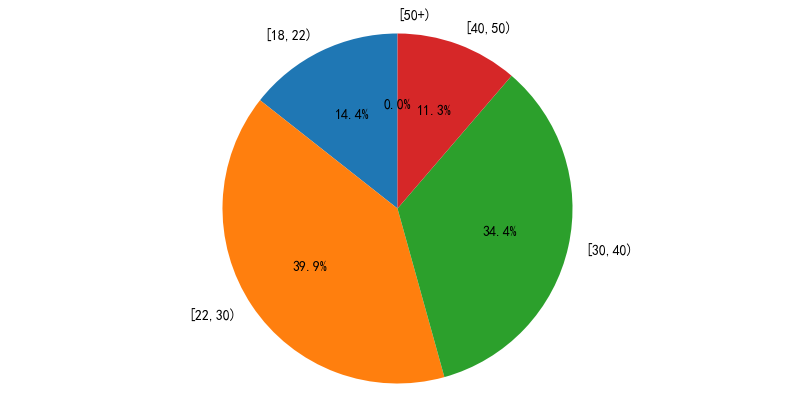

In [26]:

# 定义年龄区间
age_bins = [18, 22, 30, 40, 50, float('inf')]
age_labels = ['[18,22)', '[22,30)', '[30,40)', '[40,50)','[50+)']

# 定义年龄区间
# age_bins = [0, 23, float('inf')]
# age_labels = ['[0,23)', '[23+)']

# 使用 pd.cut 设置年龄区间
df_select['age_group'] = pd.cut(df_select['age'], bins=age_bins, labels=age_labels, right=False, include_lowest=False)

df_age = df_select.groupby('age_group').agg({'是否出库': 'count'})

plt.figure(figsize=(10, 5))
plt.pie(df_age.是否出库, labels=df_age.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()


In [27]:

df_age.loc[:, '总体']  = df_age.是否出库.sum()
df_age.loc[:, '比例'] = (df_age.是否出库/df_age.总体).map(lambda x: format(x, '.2%'))
df_age

,是否出库,总体,比例
age_group,,,
"[18,22)",3753,26098,14.38%
"[22,30)",10423,26098,39.94%
"[30,40)",8973,26098,34.38%
"[40,50)",2948,26098,11.30%
[50+),1,26098,0.00%


# 地域分布

In [28]:
df_select[['order_number', 'delivery_province_name']]

df_province1 = pd.crosstab(df_select["下单月份"],df_select["delivery_province_name"],margins=True)

df_select['delivery_province_name'] = np.where(df_select['delivery_province_name']=='上海', '上海市', 
                                        np.where(df_select['delivery_province_name']=='北京', '北京市',
                                                np.where(df_select['delivery_province_name']=='天津', '天津市',
                                                        np.where(df_select['delivery_province_name']=='重庆', '重庆市', df_select['delivery_province_name']))))
province_list = ['广东省', '江苏省', '浙江省', '福建省', '山东省', '四川省', '河南省', '河北省', '安徽省', '云南省', '湖北省', '湖南省', '江西省', '陕西省', '上海市', '辽宁省', 
                '北京市', '重庆市', '贵州省', '广西壮族自治区', '山西省', '黑龙江省', '吉林省', '甘肃省', '天津市', '海南省']
df_delivery_province_name = df_select.groupby('delivery_province_name').agg({'是否出库': 'count'})

df_delivery_province_name.loc[:, '总体']  = df_delivery_province_name.是否出库.sum()
df_delivery_province_name.loc[:, '比例'] = (df_delivery_province_name.是否出库/df_delivery_province_name.总体).map(lambda x: format(x, '.2%'))
df_delivery_province_name[['比例']]


,比例
delivery_province_name,
上海市,2.92%
云南省,3.14%
内蒙古自治区,1.62%
北京市,2.55%
吉林省,2.11%
四川省,5.36%
天津市,1.04%
宁夏回族自治区,0.46%
安徽省,4.65%


# 租赁方案

In [29]:
df_select_zl = df_select.groupby('租赁方案').agg({'order_number': 'count'})
df_select_zl.loc[:, '总体']  = df_select_zl.order_number.sum()
df_select_zl.loc[:, '比例'] = (df_select_zl.order_number/df_select_zl.总体).map(lambda x: format(x, '.2%'))
df_select_zl[['比例']]

,比例
租赁方案,
租完即送,6.98%
租完归还,93.02%


In [30]:
df_select_a = df_select[['order_number', '性别', 'age_group', 'delivery_province_name', '租赁方案']]
with pd.ExcelWriter('F:/需求/总需求/京享租准入数据.xlsx', engine='xlsxwriter') as writer:
    df_select_a.to_excel(writer, sheet_name='数据宽表', index=False)

# 前15出库机型

In [31]:
df[df['product_name'].str.contains('Watch')]['product_name']

52          Apple Watch Ultra 智能手表GPS+蜂窝款49mm钛金属原色钛金属表壳
55                           全新 Apple Watch Ultra2 智能手表
80                         全新 Apple Watch Series 9 智能手表
139                          全新 Apple Watch Ultra2 智能手表
142                          全新 Apple Watch Ultra2 智能手表
                              ...                      
28321    Airpods Pro 二代 主动降噪无线蓝牙耳机 适用iPhone/iPad/Watch 
28579    Airpods Pro 二代 主动降噪无线蓝牙耳机 适用iPhone/iPad/Watch 
28585    Airpods Pro 二代 主动降噪无线蓝牙耳机 适用iPhone/iPad/Watch 
28594    Airpods Pro 二代 主动降噪无线蓝牙耳机 适用iPhone/iPad/Watch 
28729    Airpods Pro 二代 主动降噪无线蓝牙耳机 适用iPhone/iPad/Watch 
Name: product_name, Length: 235, dtype: object

In [32]:
def xinghao_classify(a,b):
    if 'iphone15promax' in a:
        return 'iphone15promax'
    elif 'iphone14promax' in a:
        return 'iphone14promax'
    elif 'iphone16promax' in a:
        return 'iphone16promax'
    elif 'iphone15pro' in a:
        return 'iphone15pro'    
    elif 'iphone14pro' in a:
        return 'iphone14pro'
    elif 'iphone16pro' in a:
        return 'iphone16pro'
    elif 'iphone15plus' in a:
        return 'iphone15plus'
    elif 'iphone16plus' in a:
        return 'iphone16plus'  
    elif 'iphone15' in a:
        return 'iphone15' 
    elif 'iphone14' in a:
        return 'iphone14'
    elif 'iphone16' in a:
        return 'iphone16'
    elif 'mate60pro' in a:
        return 'mate60pro'
    elif 'iphone11' in a:
        return 'iphone11'
    elif 'vivoiqoo9pro' in a:
        return 'vivoiqoo9pro'
    elif 'vivox80' in a:
        return 'vivox80'
    elif 'vivoy55s' in a:
        return 'vivoy55s'
    elif 'iphone14plus' in a:
        return 'iphone14plus'
    elif 'iphone13promax' in a:
        return 'iphone13promax'
    elif 'mate60' in a:
        return 'mate60'
    elif 'watch' in a:
        return 'watch'
    elif 'iphone13pro' in a:
        return 'iphone13pro'
    elif 'vivox100pro' in a:
        return 'vivox100pro'
    elif '小米13pro' in a:
        return '小米13pro'
    elif '小米13' in a:
        return '小米13'
    elif 'iphone12promax' in a:
        return 'iphone12promax'
    elif 'iphone13' in a:
        return 'iphone13'
    elif '小米14pro' in a:
        return '小米14pro'
    elif '小米14' in a:
        return '小米14'
    elif 'iphone12pro' in a:
        return 'iphone12pro'
    elif 'ipad' in a:
        return 'ipad'
    elif 'iphone12' in a:
        return 'iphone12'
    elif '相机' in a:
        return '相机'
    elif '荣耀x50' in a:
        return '荣耀x50'
    elif 'findx6pro' in a:
        return 'findx6pro'
    elif 'xiaomi13' in a:
        return '小米13'
    elif 'vivoiqoo12pro' in a:
        return 'vivoiqoo12pro'
    elif 'oppofindn2' in a:
        return 'oppofindn2'
    elif 'redminote12turbo' in a:
        return 'redminote12turbo'
    elif 'iqoo11' in a:
        return 'iqoo11'
    elif 'vivox100' in a:
        return 'vivox100'
    elif 'mate50pro' in a:
        return 'mate50pro'
    elif 'x90' in a:
        return 'x90'
    elif 'vivoiqooneo8' in a:
        return 'vivoiqooneo8'
    elif '华为pura70pro' in a:
        return '华为pura70pro'
    elif '华为p60' in a:
        return '华为p60'
    elif 'vivoiqoo12' in a:
        return 'vivoiqoo12'
    elif 'x90pro' in a:
        return 'x90pro'
    elif '华为pura70' in a:
        return '华为pura70'
    elif 'iqooneo8pro' in a:
        return 'iqooneo8pro'
    elif 'vivot2x' in a:
        return 'vivot2x'
    elif 'oppofindx7ultra' in a:
        return 'oppofindx7ultra'
    elif 'vivoiqoo9' in a:
        return 'vivoiqoo9'
    elif 'vivoiqooneo6' in a:
        return 'vivoiqooneo6'
    elif 'magic4' in a:
        return 'magic4'
    elif 'iphone8plus' in a:
        return 'iphone8plus'
    elif 'opporeno8pro+' in a:
        return 'opporeno8pro+'
    elif '华为nova11pro' in a:
        return '华为nova11pro'
    elif 'realme真我gtneo3' in a:
        return 'realme真我gtneo3'
    elif 'vivos15' in a:
        return 'vivos15'
    elif 'vivoy76s' in a:
        return 'vivoy76s'
    elif '荣耀x40' in a:
        return '荣耀x40'
    else :
        return b

df['型号1'] = df.product_name.str.lower().str.replace(' ','')
# df.型号1.value_counts()

df.loc[:,"型号_new"] = df.apply(lambda x:xinghao_classify(x["型号1"],x['product_name']),axis=1)
df["型号_new"].value_counts()

型号_new
iphone16promax                           9321
iphone15promax                           6793
iphone15pro                              5288
iphone16pro                              1440
iphone15                                  964
                                         ... 
opporeno8pro+                               1
OPPO Reno13 全新未激活 超美小直屏 IP69满级防水 顺丰包邮       1
小米15Pro 全新未拆封 顺丰包邮                          1
华为 Mate 70Pro+ 非监管机 全新未激活 鸿蒙AI 顺丰包邮         1
vivo XFold3Pro 全新未激活 顺丰包邮                   1
Name: count, Length: 172, dtype: int64

In [33]:
df_ck = df[df['是否出库']==1]
df.groupby('型号_new').agg({'是否出库': 'sum'}).sort_values(by='是否出库', ascending=False)[:15]
df.groupby('型号_new').agg({'是否出库': 'sum'}).to_excel('F:/xxxxxxxxxxxxxxxx.xlsx')

In [34]:
def product(df):
    df['型号'] = df['product_name'].str.extract(r'(iPhone ?\d+ ?(ProMax|Pro|Plus)?)'
                                            r'|(华为 ?(Mate|Pura|畅享|P|nova) ?\d+ ?(Pro\+|Pro|Plus\+|Plus|Flip\+|Flip)?|nova ?\d+ ?(Pro\+|Pro|Ultra\+|Ultra|Flip\+|Flip)?|华为 ?nova ? Flip?)'
                                            r'|(OPPO ?(Find|Reno|A|K|R) ?)', expand=True)[0]

In [35]:
df['是否出库'].sum()

np.int64(0)

# 状态处理

In [36]:
df_new = df[df.refund_date<=datetime.now()]
df_new.groupby('order_number')['refund_date'].max()

order_number
A2024010115222618    2024-01-04
A2024010115240923    2024-01-04
A2024010116302721    2024-01-04
A2024010117154825    2024-01-04
A2024010117520266    2024-01-04
                        ...    
A20250331214108141   2025-04-03
A2025033122141353    2025-04-03
A2025033123353694    2025-04-03
A20250331235111137   2025-04-03
A20250331235445144   2025-04-03
Name: refund_date, Length: 26940, dtype: datetime64[ns]

In [37]:
df[['order_id', 'order_number', 'relet_periods', 'relet_days', 'money', 'real_pay_money', 'sesame_promo_money', 'pay_discount_money', 'refund_date', 'reality_refund_date']]

,order_id,order_number,relet_periods,relet_days,money,real_pay_money,sesame_promo_money,pay_discount_money,refund_date,reality_refund_date
0,869771,A202401011909416,0,0,1.00,1.00,0.0,0.0,2024-01-04,2024-01-01 19:34:44
1,869790,A2024010119593325,9,243,357.62,357.62,0.0,0.0,2024-01-04,2024-01-01 20:26:00
2,869579,A2024010115222618,0,0,632.96,632.96,0.0,0.0,2024-01-04,2024-01-01 17:24:14
3,869584,A2024010115240923,0,0,632.96,632.96,0.0,0.0,2024-01-04,2024-01-01 15:36:02
4,869632,A2024010116302721,0,0,366.46,366.46,0.0,0.0,2024-01-04,2024-01-02 15:48:05
...,...,...,...,...,...,...,...,...,...,...
28749,2324312,A2025033113101058,0,0,1.00,1.00,0.0,0.0,2025-04-03,2025-03-31 13:10:56
28750,2323080,A20250331103607299,0,0,1.00,1.00,0.0,0.0,2025-04-03,2025-03-31 10:57:36
28751,2323842,A2025033112032633,0,0,99.00,99.00,0.0,0.0,2025-04-03,2025-03-31 13:55:34
28752,2324078,A20250331123431269,0,0,499.70,0.00,0.0,0.0,2025-04-03,NaT


In [38]:
# df['正常还款'] = np.where((df['relet_periods']==0)&(df['relet_days']==0)&())